<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [6]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn

In [42]:
#Libreria standard
import os                               #file e cartelle
import numpy as np                      #operazioni matriciali, audio e spet sono matrici
import pandas as pd                     #leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         #grafici std
import seaborn as sns                   #grafici statistici più belli

#Audio
import librosa                          #per audio in python, calcola features ecc
import librosa.display                  #visualizzare spettrogrammi
import torchaudio                       #audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       #Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          #gestire audio a livello più "umano"

#Deep learning e SNN
import torch                            #costruzioni reti neurali
import snntorch as snn                  #estensione pytorch per SNN
from snntorch import spikegen           #converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 #costruzione e training di modelli di ml e dl
from sklearn.model_selection import train_test_split

#Altri
from tqdm import tqdm                   #aggiungere barre di progresso ai loop, quanto manca al caricamento audio


Collegamento al drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [9]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [10]:
%ls /content/drive/MyDrive/HumanData/ESC-50/


airplane/        cow/               glass_breaking/   sheep/
breathing/       crackling_fire/    hand_saw/         siren/
brushing_teeth/  crickets/          helicopter/       sneezing/
can_opening/     crow/              hen/              snoring/
car_horn/        crying_baby/       insects/          thunderstorm/
cat/             dog/               keyboard_typing/  toilet_flush/
chainsaw/        door_wood_creaks/  laughing/         train/
chirping_birds/  door_wood_knock/   mouse_click/      vacuum_cleaner/
church_bells/    drinking_sipping/  pig/              washing_machine/
clapping/        engine/            pouring_water/    water_drops/
clock_alarm/     fireworks/         rain/             wind/
clock_tick/      footsteps/         rooster/
coughing/        frog/              sea_waves/


1. Caricamento file .wav
2. Rimozione silenzio iniziale/finale
3. Normalizzare il segnale
4. Calcolo Mel-spectogramma logaritmico (db)

In [11]:
def load_and_preprocess_audio(file_path, sr=44100, n_mels=64, n_fft=1024, hop_length=512):
  #Step1: Caricare file audio
  y, _ = librosa.load(file_path, sr=sr)
  #Step2: Rimuovere il silenzio
  #DA CAPIRE SE VA BENE 60
  y, index = librosa.effects.trim(y, top_db = 60)
  #Step3: Normalizzare
  y = librosa.util.normalize(y)
  #Step4: Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Step5: Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


## Processare tutti i file audio di ESC10

In [12]:
categories= os.listdir(path='/content/drive/MyDrive/HumanData/ESC-10/')
data = []

for category in categories:
  category_path = os.path.join('/content/drive/MyDrive/HumanData/ESC-10', category)
  for file in os.listdir(category_path):

    if file.endswith('.wav'):
      file_path = os.path.join(category_path, file)
      mel_spec = load_and_preprocess_audio(file_path)

      data.append((mel_spec, category))

Visualizzare un esempio

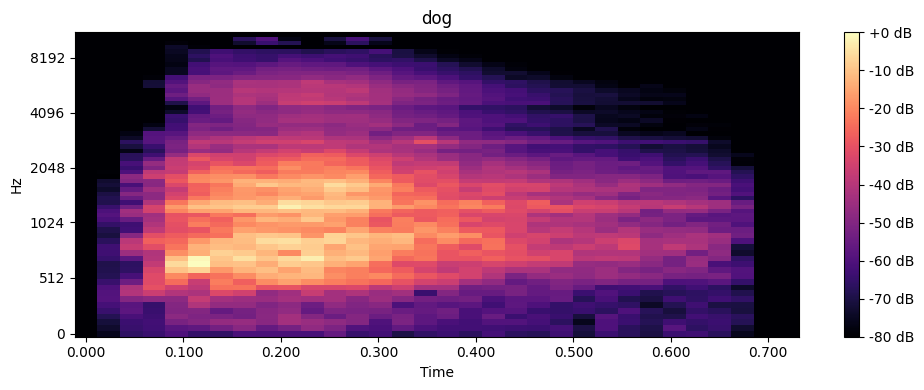

In [13]:
mel, label = data[0]
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(label)
plt.tight_layout()
plt.show()

## Convertire le etichette in numero

In [14]:
labels = sorted(set([label for _, label in data]))
label_index = {label: index for index, label in enumerate(labels)}
print(label_index)

{'chainsaw': 0, 'clock_tick': 1, 'crackling_fire': 2, 'crying_baby': 3, 'dog': 4, 'helicopter': 5, 'rain': 6, 'rooster': 7, 'sea_waves': 8, 'sneezing': 9}


In [15]:
encoded_data = []

for mel, label in data:
  index = label_index[label]
  encoded_data.append((mel, index))

In [17]:
X = [x[0] for x in encoded_data]
y = [x[1] for x in encoded_data]

I dati sono di lunghezza variabile a causa del trimming del silenzio --> devo uniformare la dimensione degli input per poterli elaborare in batch di modelli di dl. La possibile strategia potrebbe essere: padding

In [30]:
max_len = max([mel.shape[1] for mel in X])

def pad_mel(mel, max_len):
  if mel.shape[1] < max_len:
    pad_width = max_len - mel.shape[1]
    mel = np.pad(mel, pad_width=((0,0), (0, pad_width)), mode='constant')
  else:
    mel = mel[:, :max_len]
  return mel

In [31]:
X_padded = [pad_mel(mel, max_len) for mel in X]

In [33]:
X_array = np.array(X_padded)
y_array = np.array(y)

Salvataggio dei due array su '/content/drive/MyDrive/HumanData/esc10_data.npz'

In [43]:
np.savez('/content/drive/MyDrive/HumanData/esc10_data.npz', X=X_array, y=y_array)